In [1]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from torch.autograd import Variable

In [3]:
np.random.seed(0)

In [4]:
# Training data is 11 points in [0,1] inclusive regularly spaced
x = np.linspace(0,1,50)
x_tensor = Variable(torch.from_numpy(x).float())
all_index = np.arange(x.shape[0])

train_x_index = np.sort(np.random.choice(np.arange(x.shape[0]),11, replace=False))
H = np.zeros((x.shape[0], train_x_index.shape[0])).T

for q in range(train_x_index.shape[0]):
    for p in range(x.shape[0]):
        if train_x_index[q] == all_index[p]:
            H[q,p] = 1
H = H.T

train_x = x[train_x_index]
train_x = Variable(torch.from_numpy(train_x).float())

# True function is sin(2*pi*x) with Gaussian noise N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (2 * np.pi)) + torch.randn(train_x.size()) * 0.2)

In [5]:
from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [6]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, W, H):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-1,1]
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-10, 10))
        
        self.W = torch.from_numpy(W).float()
        self.H = torch.from_numpy(H).float()
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
#         print(covar_x.type())
#         print(self.W.type())
        if self.training:
#             print(covar_x.shape)
            covar_x = self.H.t().matmul(self.W.t().matmul(covar_x.matmul(self.W.matmul(self.H))))
        # Return moddl output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

# initialize likelihood and model
likelihood = GaussianLikelihood(log_noise_bounds=(-5, 5))
# W = 1*np.ones((train_x.data.shape[0], train_x.data.shape[0]), dtype=np.float)
W = np.random.randn(x.shape[0], x.shape[0])
W = np.matmul(W.T,W)

model = ExactGPModel(x_tensor.data, train_y.data, likelihood, W, H)

In [7]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 1000
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_tensor)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.data[0],
        model.covar_module.log_lengthscale.data[0, 0],
        model.likelihood.log_noise.data[0]
    ))
    optimizer.step()

/home/lerko/anaconda3/lib/python3.6/site-packages/gpytorch/functions/add_diag.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  val = diag.squeeze()[0]


Iter 1/1000 - Loss: 2.033   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/1000 - Loss: 1.934   log_lengthscale: 0.100   log_noise: -0.100
Iter 3/1000 - Loss: 2.541   log_lengthscale: 0.200   log_noise: -0.200
Iter 4/1000 - Loss: 1.952   log_lengthscale: 0.208   log_noise: -0.297
Iter 5/1000 - Loss: 2.214   log_lengthscale: 0.256   log_noise: -0.394
Iter 6/1000 - Loss: 2.141   log_lengthscale: 0.272   log_noise: -0.492
Iter 7/1000 - Loss: 2.040   log_lengthscale: 0.240   log_noise: -0.588
Iter 8/1000 - Loss: 1.900   log_lengthscale: 0.228   log_noise: -0.685
Iter 9/1000 - Loss: 2.149   log_lengthscale: 0.222   log_noise: -0.780
Iter 10/1000 - Loss: 2.037   log_lengthscale: 0.215   log_noise: -0.874
Iter 11/1000 - Loss: 2.186   log_lengthscale: 0.244   log_noise: -0.965
Iter 12/1000 - Loss: 1.823   log_lengthscale: 0.293   log_noise: -1.052
Iter 13/1000 - Loss: 1.524   log_lengthscale: 0.344   log_noise: -1.137
Iter 14/1000 - Loss: 1.604   log_lengthscale: 0.374   log_noise: -1.222
It

Iter 133/1000 - Loss: 1.664   log_lengthscale: 2.837   log_noise: -0.823
Iter 134/1000 - Loss: 1.582   log_lengthscale: 2.845   log_noise: -0.819
Iter 135/1000 - Loss: 1.720   log_lengthscale: 2.855   log_noise: -0.816
Iter 136/1000 - Loss: 1.574   log_lengthscale: 2.860   log_noise: -0.812
Iter 137/1000 - Loss: 1.850   log_lengthscale: 2.875   log_noise: -0.810
Iter 138/1000 - Loss: 1.886   log_lengthscale: 2.899   log_noise: -0.804
Iter 139/1000 - Loss: 1.648   log_lengthscale: 2.936   log_noise: -0.790
Iter 140/1000 - Loss: 1.947   log_lengthscale: 2.977   log_noise: -0.777
Iter 141/1000 - Loss: 2.062   log_lengthscale: 2.999   log_noise: -0.764
Iter 142/1000 - Loss: 2.109   log_lengthscale: 3.021   log_noise: -0.747
Iter 143/1000 - Loss: 1.868   log_lengthscale: 3.044   log_noise: -0.730
Iter 144/1000 - Loss: 1.537   log_lengthscale: 3.054   log_noise: -0.717
Iter 145/1000 - Loss: 1.360   log_lengthscale: 3.063   log_noise: -0.712
Iter 146/1000 - Loss: 1.822   log_lengthscale: 3.05

Iter 271/1000 - Loss: 1.649   log_lengthscale: 4.946   log_noise: -0.824
Iter 272/1000 - Loss: 1.892   log_lengthscale: 4.944   log_noise: -0.829
Iter 273/1000 - Loss: 1.550   log_lengthscale: 4.945   log_noise: -0.828
Iter 274/1000 - Loss: 1.849   log_lengthscale: 4.942   log_noise: -0.829
Iter 275/1000 - Loss: 1.800   log_lengthscale: 4.934   log_noise: -0.823
Iter 276/1000 - Loss: 1.552   log_lengthscale: 4.926   log_noise: -0.815
Iter 277/1000 - Loss: 1.550   log_lengthscale: 4.919   log_noise: -0.809
Iter 278/1000 - Loss: 1.295   log_lengthscale: 4.909   log_noise: -0.807
Iter 279/1000 - Loss: 1.414   log_lengthscale: 4.902   log_noise: -0.812
Iter 280/1000 - Loss: 1.353   log_lengthscale: 4.897   log_noise: -0.822
Iter 281/1000 - Loss: 1.307   log_lengthscale: 4.892   log_noise: -0.837
Iter 282/1000 - Loss: 1.969   log_lengthscale: 4.897   log_noise: -0.856
Iter 283/1000 - Loss: 1.670   log_lengthscale: 4.892   log_noise: -0.861
Iter 284/1000 - Loss: 1.235   log_lengthscale: 4.88

Iter 410/1000 - Loss: 1.431   log_lengthscale: 5.685   log_noise: -0.832
Iter 411/1000 - Loss: 1.572   log_lengthscale: 5.698   log_noise: -0.822
Iter 412/1000 - Loss: 1.678   log_lengthscale: 5.709   log_noise: -0.815
Iter 413/1000 - Loss: 1.651   log_lengthscale: 5.726   log_noise: -0.802
Iter 414/1000 - Loss: 1.479   log_lengthscale: 5.732   log_noise: -0.792
Iter 415/1000 - Loss: 1.787   log_lengthscale: 5.736   log_noise: -0.789
Iter 416/1000 - Loss: 1.489   log_lengthscale: 5.740   log_noise: -0.780
Iter 417/1000 - Loss: 1.499   log_lengthscale: 5.744   log_noise: -0.782
Iter 418/1000 - Loss: 1.809   log_lengthscale: 5.754   log_noise: -0.792
Iter 419/1000 - Loss: 1.734   log_lengthscale: 5.767   log_noise: -0.802
Iter 420/1000 - Loss: 1.582   log_lengthscale: 5.782   log_noise: -0.811
Iter 421/1000 - Loss: 1.827   log_lengthscale: 5.800   log_noise: -0.817
Iter 422/1000 - Loss: 1.705   log_lengthscale: 5.809   log_noise: -0.815
Iter 423/1000 - Loss: 1.434   log_lengthscale: 5.82

Iter 549/1000 - Loss: 1.425   log_lengthscale: 6.711   log_noise: -0.736
Iter 550/1000 - Loss: 1.501   log_lengthscale: 6.714   log_noise: -0.742
Iter 551/1000 - Loss: 1.598   log_lengthscale: 6.718   log_noise: -0.758
Iter 552/1000 - Loss: 1.333   log_lengthscale: 6.721   log_noise: -0.771
Iter 553/1000 - Loss: 1.260   log_lengthscale: 6.723   log_noise: -0.794
Iter 554/1000 - Loss: 1.207   log_lengthscale: 6.725   log_noise: -0.824
Iter 555/1000 - Loss: 1.805   log_lengthscale: 6.726   log_noise: -0.861
Iter 556/1000 - Loss: 1.586   log_lengthscale: 6.724   log_noise: -0.877
Iter 557/1000 - Loss: 1.647   log_lengthscale: 6.719   log_noise: -0.887
Iter 558/1000 - Loss: 1.800   log_lengthscale: 6.713   log_noise: -0.888
Iter 559/1000 - Loss: 1.503   log_lengthscale: 6.709   log_noise: -0.876
Iter 560/1000 - Loss: 1.590   log_lengthscale: 6.705   log_noise: -0.862
Iter 561/1000 - Loss: 1.682   log_lengthscale: 6.701   log_noise: -0.842
Iter 562/1000 - Loss: 1.298   log_lengthscale: 6.69

Iter 686/1000 - Loss: 1.288   log_lengthscale: 7.606   log_noise: -0.822
Iter 687/1000 - Loss: 1.472   log_lengthscale: 7.615   log_noise: -0.838
Iter 688/1000 - Loss: 1.518   log_lengthscale: 7.624   log_noise: -0.845
Iter 689/1000 - Loss: 1.539   log_lengthscale: 7.632   log_noise: -0.853
Iter 690/1000 - Loss: 1.169   log_lengthscale: 7.640   log_noise: -0.856
Iter 691/1000 - Loss: 1.481   log_lengthscale: 7.648   log_noise: -0.863
Iter 692/1000 - Loss: 1.775   log_lengthscale: 7.655   log_noise: -0.864
Iter 693/1000 - Loss: 1.559   log_lengthscale: 7.662   log_noise: -0.846
Iter 694/1000 - Loss: 1.255   log_lengthscale: 7.669   log_noise: -0.823
Iter 695/1000 - Loss: 1.396   log_lengthscale: 7.675   log_noise: -0.813
Iter 696/1000 - Loss: 1.295   log_lengthscale: 7.681   log_noise: -0.807
Iter 697/1000 - Loss: 1.631   log_lengthscale: 7.687   log_noise: -0.810
Iter 698/1000 - Loss: 1.473   log_lengthscale: 7.692   log_noise: -0.808
Iter 699/1000 - Loss: 1.209   log_lengthscale: 7.69

Iter 827/1000 - Loss: 1.707   log_lengthscale: 8.296   log_noise: -0.873
Iter 828/1000 - Loss: 1.662   log_lengthscale: 8.299   log_noise: -0.865
Iter 829/1000 - Loss: 1.181   log_lengthscale: 8.303   log_noise: -0.849
Iter 830/1000 - Loss: 1.452   log_lengthscale: 8.307   log_noise: -0.839
Iter 831/1000 - Loss: 1.526   log_lengthscale: 8.311   log_noise: -0.832
Iter 832/1000 - Loss: 1.530   log_lengthscale: 8.314   log_noise: -0.820
Iter 833/1000 - Loss: 1.344   log_lengthscale: 8.318   log_noise: -0.806
Iter 834/1000 - Loss: 1.521   log_lengthscale: 8.321   log_noise: -0.804
Iter 835/1000 - Loss: 1.722   log_lengthscale: 8.324   log_noise: -0.796
Iter 836/1000 - Loss: 1.310   log_lengthscale: 8.329   log_noise: -0.786
Iter 837/1000 - Loss: 1.273   log_lengthscale: 8.333   log_noise: -0.784
Iter 838/1000 - Loss: 2.131   log_lengthscale: 8.338   log_noise: -0.786
Iter 839/1000 - Loss: 1.455   log_lengthscale: 8.343   log_noise: -0.779
Iter 840/1000 - Loss: 1.472   log_lengthscale: 8.34

Iter 965/1000 - Loss: 1.704   log_lengthscale: 8.658   log_noise: -0.862
Iter 966/1000 - Loss: 1.478   log_lengthscale: 8.657   log_noise: -0.858
Iter 967/1000 - Loss: 1.323   log_lengthscale: 8.657   log_noise: -0.848
Iter 968/1000 - Loss: 1.314   log_lengthscale: 8.658   log_noise: -0.839
Iter 969/1000 - Loss: 1.286   log_lengthscale: 8.658   log_noise: -0.835
Iter 970/1000 - Loss: 1.763   log_lengthscale: 8.658   log_noise: -0.838
Iter 971/1000 - Loss: 1.380   log_lengthscale: 8.658   log_noise: -0.831
Iter 972/1000 - Loss: 1.341   log_lengthscale: 8.657   log_noise: -0.825
Iter 973/1000 - Loss: 1.426   log_lengthscale: 8.656   log_noise: -0.824
Iter 974/1000 - Loss: 1.301   log_lengthscale: 8.657   log_noise: -0.823
Iter 975/1000 - Loss: 1.532   log_lengthscale: 8.656   log_noise: -0.831
Iter 976/1000 - Loss: 1.965   log_lengthscale: 8.656   log_noise: -0.833
Iter 977/1000 - Loss: 1.312   log_lengthscale: 8.655   log_noise: -0.823
Iter 978/1000 - Loss: 1.376   log_lengthscale: 8.65

/home/lerko/anaconda3/lib/python3.6/site-packages/gpytorch/functions/add_diag.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  val = diag.squeeze()[0]


ValueError: Argument dimensions are incompatible

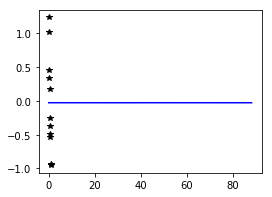

In [10]:
# Put model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are regularly spaced along [0,1] every 0.02
# Make predictions by feeding model through likelihood
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(x_tensor))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Get upper and lower confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_tensor.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot the predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')

In [ ]:
torch.cuda.is_available()


In [ ]:
torch.Tensor().cuda()

In [ ]:
observed_pred.mean().shape

In [ ]:
train_y.data.numpy().shape

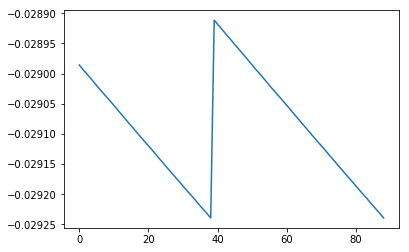

In [13]:
plt.plot(observed_pred.mean().data.numpy())